Uses results from aperture photometry to derive the optical depth of the atmosphere for a given night of observing.
Does the following:
- Fits star flux as a function of airmass to find an average optical depth as a function of wavelength for the night.

Still needs to be added to notebook:
- Uses optical depth with each star cube to find an F_top for each star cube
- Takes the median of F_top
- Uses F_top to find beta (photometric conversion factor)

In [1]:
import numpy as np
from numpy import pi, r_
from astropy.io import fits
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import math
from scipy import interpolate
from scipy import optimize
from collections import OrderedDict
from uncertainties import ufloat
from uncertainties.umath import *  # sin(), etc.
#>>> x = ufloat(1, 0.1)  # x = 1+/-0.1

### Functions

In [5]:
def F_obs(chi,tau,F_top):
    # Function to use with curve_fit() to get tau
    # F_top falls off with -tau*chi to give you F_obs
    return F_top*np.e**(-tau*chi)

def Ftop(chi,tau,F_obs):
    # returns the flux at the top of the atmosphere by correcting for the atm
    return F_obs*np.e**(tau*chi)

def flux1(mag1,mag2,flux2):
    # Useful for returning the flux of a star if it were scaled to Vega's magnitude.
    # flux1 = Star's flux as Vega
    # flux2 = Star's measured flux
    # mag1 = Vega's flux
    # mag2 = Star's flux
    return flux2*(10**(0.4*(mag2-mag1)))

def flux_relative_to_vega(mag2,flux2):
    # Same as flux1, but with Vega's magnitude hard-coded.
    # returns Star's flux as Vega
    # flux2 = Star's measured flux
    # mag2 = Star's flux
    mag1 = 0.03 # Vega's V magnitude
    return flux2*(10**(0.4*(mag2-mag1)))

### Find the optical depth of the atmosphere for the night

In [ ]:
def tau_flux_fit(science_directory, science_list, starlist_directory, star_directory, snr_limit, wl_range):
    
    # science_directory = location of Jupiter cube
    # science_list = location+name of Jupiter image list
    # starlist_directory = location of image name lists for each cube. !!Assumes that name of star image lists are star1, star2, etc.
    # star_directory = location of star fits files
    # snr_limit = won't include fluxes below that range while calculating tau (previously used ~25)
    # tau_fit_wl_range = range of wl in nm that's considered by the program when fitting a given wl point (typical values 2-5)
    # Note: there are values for snr_limit and wl_range in Paul's thesis, but they might not be directly applicable to our observations. There's a trade-off between wavelength range and SNR in order to provide the function with enough data points to fit. Lower wl range needs a lower SNR, and vice versa. Values I used for March 2017 were snr_limit = 25, wl_range=8.
    
    # Make sure standard stars don't have significant reddening (that V mag is approximately average/representative of other magnitudes)
    # Star lists need to be named star1, star2, etc.
    # Doesn't require that you saved files of star flux from Ap_phot
    
    # Pulls information from star cubes, assuming they've already been through Ap_phot. Uses airmass, flux, and magnitude information to scale the stars to Vega, calculate an 
    
    
    wl_sci = np.linspace(470,950,241) # These are the wavelengths that tau will be derived for
    # Otherwise, do this:
    # Pull wavelengths to analyze from science cube
    '''print 'Pulling wavelength array from science images...'
    wl_sci = []
    sciencelist = np.loadtxt(science_list,dtype=str)
    for i in range(0,len(sciencelist)):
        im = fits.open(science_directory+sciencelist[i])
        if im[0].header['rfon'] == 1:
            wl_sci.append(im[0].header['lambda'])
        im.close()'''
    
    tau = []
    tau_error = []
    
    # Quieries:
    num_stars = raw_input('How many individual stars were imaged? ')
        
    num_cubes = int(raw_input('How many total cubes are there? '))
    
    V_mags = []
    for i in range(0,int(num_cubes)):
        mags = raw_input('For cube '+str(i+1)+', what is it\'s V magnitude? ')
        V_mags.append(float(mags)) # will be same length of number of star cubes
    
    photometric_quality_query = raw_input('If photometric info (keyword PHOTTEST) is saved in the header, do you want to save that information? y/n ')
    
    airmass_plot_query = raw_input('Do you want to see a plot of airmasses for all of the star cubes? y/n ')
    snr_plot_query = raw_input('Do you want to see a plot of the SNR spectrum for each star cube? y/n ')
    flux_plot_query = raw_input('Do you want to see a plot of the stars\'s flux? y/n ')
    tau_plot_query = raw_input('Do you want to see plots of optical depth fits for each wavelength? (warning: can slow down the fitting process quite a bit) y/n ')
    
    
    
    # load star lists into dictionaries
    star_list_dict = OrderedDict()
    for i in range(0,num_cubes):
        star_list_dict['star'+str(i+1)+'_list'] = np.loadtxt(starlist_directory+'star'+str(i+1),dtype=str) # appends star lists in the wrong direction, but okay as long as we're consistent
        
    
    # Pull airmasses, wavelengths, star flux, and snr of each image from from each image header from each cube and assign them to a dictionary
    
    # Make empty dictionaries
    airmass_dict = OrderedDict(); airmass_wl_dict = OrderedDict(); star_snr_dict = OrderedDict(); star_flux_dict = OrderedDict()
    
    # pulling these for plotting purposes
    for i in range(0,len(star_list_dict)):
        airmass_list = []; airmass_wl_list = []; star_snr_list = []; star_flux_list = []
        for j in star_list_dict['star'+str(i+1)+'_list']: # for each star cube
            #print j # Each image in the list
            im = fits.open(star_directory+str(j))
            if im[0].header['rfon'] == 1:
                airmass_list.append(im[0].header['airmass'])
                airmass_wl_list.append(im[0].header['lambda'])
                star_snr_list.append(im[0].header['star_snr'])    
                star_flux_list.append(im[0].header['star_flx'])
            im.close()
        airmass_dict['airmass_star'+str(i+1)] = airmass_list # dictionary of airmasses
        airmass_wl_dict['airmass_wl_star'+str(i+1)] = airmass_wl_list # dictionary of wavelngths corresponding to airmasses (and other qualities appended above)
        star_snr_dict['snr_star'+str(i+1)] = star_snr_list # dictionary of SNR
        star_flux_dict['flux_star'+str(i+1)] = star_flux_list # dictionary of star flux
        
    # Plot airmass coverage
    if airmass_plot_query == 'y':
        for j in range(0,len(airmass_dict)):
            plt.plot(airmass_dict['airmass_star'+str(j+1)], airmass_wl_dict['airmass_wl_star'+str(j+1)],'.')
        plt.title('Airmass coverage')
        plt.ylabel('Wavelength')
        plt.xlabel('Airmass')
        plt.legend(airmass_dict.keys())
        plt.show()
        
    # Plot SNR spectra
    if snr_plot_query == 'y':
        for j in range(0,len(airmass_wl_dict)):
            plt.plot(airmass_wl_dict['airmass_wl_star'+str(j+1)], star_snr_dict['snr_star'+str(j+1)], '.')
        plt.title('SNR of All Cubes')
        plt.ylabel('SNR')
        plt.xlabel('Wavelength')
        plt.legend(star_snr_dict.keys())
        plt.show()
        
    # Plot flux spectra
    if flux_plot_query == 'y':
        for j in range(0,len(airmass_wl_dict)):
            plt.plot(airmass_wl_dict['airmass_wl_star'+str(j+1)], star_flux_dict['flux_star'+str(j+1)])
        plt.title('Star Flux')
        plt.ylabel('Flux (counts/sec)')
        plt.xlabel('Wavelength')
        plt.legend(star_flux_dict.keys())
        plt.show()
                
    # Scale spectra to Vega's magntiude and plot them
    for j in range(0,len(airmass_wl_dict)):
        plt.plot(airmass_wl_dict['airmass_wl_star'+str(j+1)],\
        flux_relative_to_vega(V_mags[j],np.array(star_flux_dict['flux_star'+str(j+1)])))
    plt.title('Fluxes scaled to Vega')
    plt.ylabel('DN/sec')
    plt.xlabel('Wavelength')
    plt.show()
    
    # save photometric test if done previously/desired (not a lot of evidence accounting for this improves photometric cal in the end)
    if photometric_quality_query == 'y':
        phot_qual_dict = OrderedDict()
        for i in range(0,len(star_list_dict)):
            phot_qual_list = []
            for j in star_list_dict['star'+str(i+1)+'_list']: # for each star cube
                im = fits.open(star_directory+str(j))
                if im[0].header['rfon'] == 1:
                    phot_qual_list.append(im[0].header['phottest']) # 1 if photometric, 0 if not.
                im.close()
            phot_qual_dict['phot_qual_star'+str(i+1)] = phot_qual_list # dictionary of airmasses

            
            
            
    print 'Finding an average tau value...'
    
    
    # Find tau for each science wavelength
    for i in range(0,len(wl_sci)):
        
        print wl_sci[i]
        
        flux = []
        airmass = []
        
         # loop through cubes
        for k in range(0,len(star_list_dict)):
            
            # loop through each image for a given cube
            for j in range(0,len(star_list_dict['star'+str(k+1)+'_list'])): # for each star cube
                im = fits.open(star_directory+str(star_list_dict['star'+str(k+1)+'_list'][j]))
                if im[0].header['rfon'] == 1:
                    if im[0].header['star_snr'] >= snr_limit:
                        
                        if photometric_quality_query == 'y':
                            if im[0].header['phottest'] == 1:
                                if im[0].header['lambda'] > (wl_sci[i]-wl_range) and im[0].header['lambda'] < (wl_sci[i]+wl_range):
                                    flux.append(flux_relative_to_vega(V_mags[k], im[0].header['star_flx'])) # append Vega-scaled flux
                                    airmass.append(im[0].header['airmass'])

                        else:
                            if im[0].header['lambda'] > (wl_sci[i]-wl_range) and im[0].header['lambda'] < (wl_sci[i]+wl_range):
                                flux.append(flux_relative_to_vega(V_mags[k], im[0].header['star_flx'])) # append Vega-scaled flux
                                airmass.append(im[0].header['airmass'])

                im.close()
        
        # for a given wavelength, sort airmass and flux
        dummy = np.zeros((len(airmass),2))
        dummy[:,0] = airmass
        dummy[:,1] = flux
        dummy = sorted(dummy, key=lambda a_entry: a_entry[0])
        
        #Make them lists again
        airmass_sorted = []
        flux_sorted = []
        for x in range(0,len(dummy)):
            airmass_sorted.append(dummy[x][0])
            flux_sorted.append(dummy[x][1])
        
        # Fit the values for a given wavelength using the equations defined previously
        guess = np.array((0.01,1e3)) # Does this work??
        popt, pcov = curve_fit(F_obs, airmass_sorted, flux_sorted,guess) # curve_fit(Function to fit, xdata, ydata)
        
        if tau_plot_query == 'y':
            plt.plot(airmass_sorted, F_obs(np.array(airmass_sorted),*popt), 'r-', label='fit')
            plt.plot(airmass_sorted, flux_sorted, 'b.', label='data')
            plt.title(wl_sci[i])
            plt.ylabel('flux')
            plt.xlabel('airmass')
            plt.show()
        
        perr = np.sqrt(np.diag(pcov))
        #print perr[0] # error on tau

        #print 'tau: ',(popt[0]),'+-',perr[0],' ',wl_sci[i]
        if popt[0] < 0:
            print 'Warning!! Optical depth at '+str(wl_sci[i])+' less than 0.'
        tau.append(popt[0])
        tau_error.append(perr[0])
    return tau, tau_error

In [ ]:
# Sample use:

In [ ]:
tau,tau_error = tau_flux_fit('/Volumes/external_hd/march2017/redo/jupiter/',\
            '/Volumes/external_hd/march2017/march_2017_sciimages',\
            '/Volumes/external_hd/march2017/redo/calstars/',\
            '/Volumes/external_hd/march2017/redo/calstars/',25,4)

In [ ]:
wl_sci = np.linspace(470,950,241)
plt.errorbar(wl_sci,tau,color='blue',ecolor='g',yerr=np.array(tau_error))
plt.show()

In [ ]:
# save tau and error to text file
wl_sci = np.linspace(470,950,241)
dummy = np.zeros((len(tau),3))
dummy[:,0] = wl_sci
dummy[:,1] = tau
dummy[:,2] = tau_error
np.savetxt('/Volumes/external_hd/march2017/redo/tau_march2017',dummy)

In [2]:
# for tests:
tau = np.loadtxt('/Volumes/external_hd/march2017/redo/tau_march2017')[:,1]
tau_error = np.loadtxt('/Volumes/external_hd/march2017/redo/tau_march2017')[:,2]
tau_wl = np.loadtxt('/Volumes/external_hd/march2017/redo/tau_march2017')[:,0]

### Find a median F_top (cal star flux at the top of the atmosphere)

Be sure to have tau and tau_error saved from Tau_flux_fit routine above; or, read it in from a text file

In [3]:
def F_top_finder(starlist_directory, star_directory,tau,tau_error,tau_wl=0):
    # Uses optical depth to find flux at the top of the atmosphere for each star cube; uses those fluxes to find a median F_top. Science wavelengths are hard-coded for NAIC.
    # starlist_directory = location of image name lists for each cube. !!Assumes that name of star image lists are star1, star2, etc.
    # star_directory = location of star fits files
    # tau, tau_error - from ap_phot
    # tau_wl - include as an array, in the instance of tau being derived at wavelengths different than images
    
    wl_sci = np.linspace(470,950,241)
    
    num_stars = raw_input('How many individual stars were imaged? ')
        
    num_cubes = int(raw_input('How many total cubes are there? '))
    
    V_mags = []
    for i in range(0,int(num_cubes)):
        mags = raw_input('For cube '+str(i+1)+', what is it\'s V magnitude? ')
        V_mags.append(float(mags)) # will be same length of number of star cubes
        
    F_top_plot_query = raw_input('Do you want to see plots of all of the calculated F_top? y/n ')
    
    print 'Making dictionaries...'
    # load star lists into dictionaries
    star_list_dict = OrderedDict()
    for i in range(0,num_cubes):
        star_list_dict['star'+str(i+1)+'_list'] = np.loadtxt(starlist_directory+'star'+str(i+1),dtype=str)
        
    airmass_dict = OrderedDict(); airmass_wl_dict = OrderedDict()
    # Pull airmasses from stars; make dictionary
    for i in range(0,len(star_list_dict)):
        airmass_list = []; airmass_wl_list = []
        for j in star_list_dict['star'+str(i+1)+'_list']: # for each star cube
            #print j # Each image in the list
            im = fits.open(star_directory+str(j))
            if im[0].header['rfon'] == 1:
                airmass_list.append(im[0].header['airmass'])
                airmass_wl_list.append(im[0].header['lambda'])
            im.close()
        airmass_dict['airmass_star'+str(i+1)] = airmass_list # dictionary of airmasses
        airmass_wl_dict['airmass_wl_star'+str(i+1)] = airmass_wl_list # dictionary of wavelngths corresponding to airmasses (and other qualities appended above)
    
    # Find F_top for each cube:
    F_top_dict = OrderedDict()
    for i in range(0,len(star_list_dict)):       
        print 'Finding F_top for each cube '+str(i+1)+'...'
        F_top_list = []
        for j in range(0,len(star_list_dict['star'+str(i+1)+'_list'])): # for each star cube
            im = fits.open(star_directory+str(star_list_dict['star'+str(i+1)+'_list'][j]))
            if im[0].header['rfon'] == 1:
                
                # Find the tau that equals the wavelength of the image
                for k in range(0,len(wl_sci)):
                    if tau_wl.any() != 0:
                        if tau_wl[k] == im[0].header['lambda']: # if wavelengths tau was found at are different than those in the image headers
                            optical_depth = tau[k]
                    else:
                        if wl_sci[k] == im[0].header['lambda']:
                            optical_depth = tau[k]
                        
                # Calculate F_top, save it to a dictionary
                tau_with_error = ufloat(tau[k],tau_error[k])
                F_top_list.append( Ftop( im[0].header['airmass'], tau_with_error, flux_relative_to_vega(V_mags[i], im[0].header['star_flx'])) )
        F_top_dict['F_top_'+str(i)] = np.array(F_top_list)
                
    # Plot F_tops if you want to
    if F_top_plot_query == 'y':
        for i in range(0,len(F_top_dict)):
            ftop = []
            for j in range(0,len(F_top_dict['F_top_'+str(i)])):
                ftop.append(F_top_dict['F_top_'+str(i)][j].nominal_value)
            plt.plot(airmass_wl_dict['airmass_wl_star'+str(i+1)], ftop)
        plt.ylabel('Flux, DN/sec')
        plt.xlabel('Wavelength (nm)')
        plt.title('F_top for each cube')
        plt.legend(F_top_dict.keys())
        plt.show()
        
    # calculate median F_top from individual F_tops
    F_top_median = []
    for h in range(0,len(wl_sci)):
        F_top_median_dummy = []
        for j in range(0,len(F_top_dict)):
            F_top_median_dummy.append(F_top_dict.values()[j][h])
        F_top_median.append(np.median(F_top_median_dummy))
        
    # seperate and save values and error
    F_top_median_nominal = []
    F_top_median_error = []
    for x in range(0,len(F_top_median)):
        F_top_median_nominal.append(F_top_median[x].nominal_value)
        F_top_median_error.append(F_top_median[x].std_dev)
        
    plt.plot(wl_sci,F_top_median_nominal)
    plt.title('Median F_top value, scaled to Vega')
    plt.ylabel('Flux, DN/sec')
    plt.xlabel('Wavelength (nm)')
    plt.show()
    
    # return median F_top and error 
    return F_top_median_nominal, F_top_median_error


How many individual stars were imaged? 1
How many total cubes are there? 5
For cube 1, what is it's V magnitude? 5.48
For cube 2, what is it's V magnitude? 5.48
For cube 3, what is it's V magnitude? 5.48
For cube 4, what is it's V magnitude? 5.48
For cube 5, what is it's V magnitude? 5.48
Do you want to see plots of all of the calculated F_top? y/n y
Making dictionaries...
Finding F_top for each cube 0...
Finding F_top for each cube 1...
Finding F_top for each cube 2...
Finding F_top for each cube 3...
Finding F_top for each cube 4...


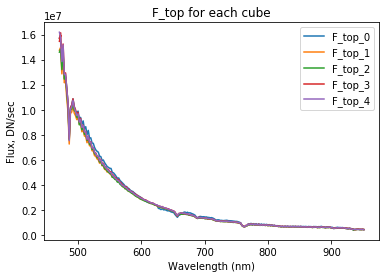

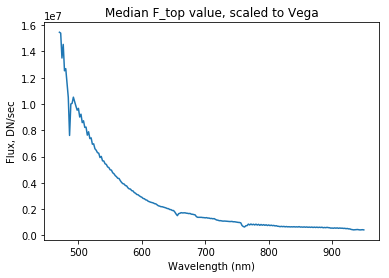

In [31]:
f_top, f_top_error = F_top_finder('/Volumes/external_hd/march2017/redo/calstars/',\
            '/Volumes/external_hd/march2017/redo/calstars/',tau,tau_error,tau_wl)

In [33]:
# save median F_top and error to a text file
wl_sci = np.linspace(470,950,241)
dummy = np.zeros((len(f_top),3))
dummy[:,0] = wl_sci
dummy[:,1] = f_top
dummy[:,2] = f_top_error
np.savetxt('/Users/dahlek/Desktop/f_top_test_2020',dummy)

### Finding photometric conversion factor, Beta

In [34]:
def beta_finder(F_vega,F_top_median,F_top_median_error):
    
    # Use median F_top to find median Beta (photometric conversion factor)
    # Beta both accounts for atmospheric effects and converts DN/sec to phydical units.
    # The standard Vega spectrum is from Kurucz (http://kurucz.harvard.edu/stars/vega/), and has been convolved with NAIC filter transmission functions. 
    # Assuming Kurucz spectra have 5% error associated with them.
    
    # F_vega - model Vega spectrum from http://kurucz.harvard.edu/stars/vega/, interpolated at NAIC wavelengths and convolved with NAIC filter functions
    # F_top_median - median F_top value from F_top_finder()
    # F_top_median_error - median F_top error from F_top_finder()
    
    # NAIC wavelengths
    wl_sci = np.linspace(470,950,241)
    
    # Set up errors
    F_vega_with_error = []
    F_top_median_with_error = []
    for i in range(0,len(wl_sci)):
        F_vega_with_error.append(ufloat(F_vega[i], 0.05*F_vega[i]))
        F_top_median_with_error.append(ufloat(F_top_median[i], F_top_median_error[i]))
    
    # Find beta, seperate error and value:
    beta = []
    beta_error = []
    beta_nominal_value = []
    for i in range(0,len(wl_sci)):
        beta.append(F_vega_with_error[i]/F_top_median_with_error[i])
        beta_error.append(beta[i].std_dev)
        beta_nominal_value.append(beta[i].nominal_value)

        
    plt.plot(wl_sci,beta_nominal_value)
    plt.errorbar(wl_sci, beta_nominal_value, color='blue', ecolor='g', yerr=np.array(beta_error))
    plt.show()
    
    return beta_nominal_value, beta_error

In [35]:
F_V = np.loadtxt('/Users/dahlek/Desktop/Vega_and_solar_Kurucz_spectra')[:,1]

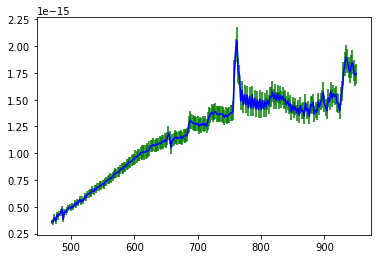

In [36]:
beta, beta_error = beta_finder(F_V,f_top,f_top_error)